# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.009558,True,6.203421
1,-0.061189,False,-0.027421
2,3.073129,True,5.173313
3,0.718875,True,5.496898
4,-0.277039,False,-0.577624
...,...,...,...
995,0.526608,False,0.002154
996,1.485738,True,7.133808
997,0.232238,True,4.353514
998,-0.276779,True,5.005542


<AxesSubplot:xlabel='v0'>

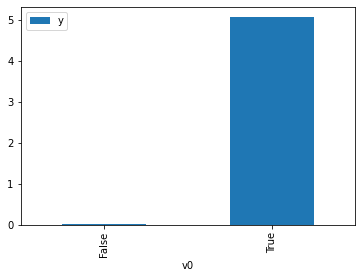

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

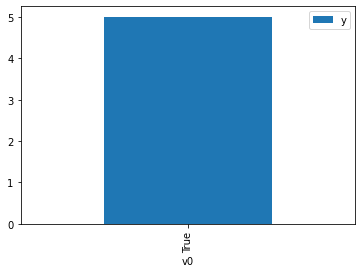

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.636650,False,0.904063,0.130909,7.638918
1,0.231633,False,0.384380,0.461040,2.169009
2,-0.570867,False,-0.504704,0.604290,1.654835
3,0.087973,False,0.311471,0.486900,2.053810
4,-0.139579,False,1.226987,0.527950,1.894120
...,...,...,...,...,...
995,0.920602,False,0.441798,0.342157,2.922638
996,-0.359794,False,-0.762239,0.567325,1.762659
997,1.830038,False,0.387263,0.212411,4.707847
998,-0.912511,False,1.676137,0.661524,1.511662


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.410621,True,3.320696,0.570873,1.751703
1,-0.562292,True,5.913271,0.397192,2.517675
2,0.176476,True,5.411929,0.529048,1.890186
3,-0.049614,True,7.180348,0.488265,2.048067
4,1.222870,True,6.454600,0.705158,1.418122
...,...,...,...,...,...
995,0.358995,True,4.567894,0.561716,1.780258
996,1.452603,True,2.436958,0.738442,1.354203
997,0.190055,True,5.493745,0.531491,1.881500
998,0.196278,True,3.597658,0.532610,1.877547


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              6640.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):                        0.00
Time:                        14:58:58   Log-Likelihood:                         -1437.5
No. Observations:                1000   AIC:                                      2879.
Df Residuals:                     998   BIC:                                      2889.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4485      0.031     14.409      0.000       0.387       0.510
x2             5.0276      0.047    106.667      0.000       4.935       5.120
==============================================================================
Omnibus:                        0.614   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.695
Skew:                          -0.047   Prob(JB):                        0.706
Kurtosis:                       2.912   Cond. No.                         1.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""